In [1]:
# Iterative version of Conway's game of life in Python / CUDA C
# written by Brian Tuomanen for "Hands on GPU Programming with Python and CUDA"

import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
ker = SourceModule("""
#define _X  ( threadIdx.x + blockIdx.x * blockDim.x )
#define _Y  ( threadIdx.y + blockIdx.y * blockDim.y )

#define _WIDTH  ( blockDim.x * gridDim.x )
#define _HEIGHT ( blockDim.y * gridDim.y  )

#define _XM(x)  ( (x + _WIDTH) % _WIDTH )
#define _YM(y)  ( (y + _HEIGHT) % _HEIGHT )

#define _INDEX(x,y)  ( _XM(x)  + _YM(y) * _WIDTH )

// return the number of living neighbors for a given cell                
__device__ int nbrs(int x, int y, int * in)
{
     return ( in[ _INDEX(x -1, y+1) ] + in[ _INDEX(x-1, y) ] + in[ _INDEX(x-1, y-1) ] \
                   + in[ _INDEX(x, y+1)] + in[_INDEX(x, y - 1)] \
                   + in[ _INDEX(x+1, y+1) ] + in[ _INDEX(x+1, y) ] + in[ _INDEX(x+1, y-1) ] );
}

__global__ void conway_ker(int * lattice, int iters)
{
   // x, y are the appropriate values for the cell covered by this thread
   int x = _X, y = _Y;
   
   for (int i = 0; i < iters; i++)
   {
   
       // count the number of neighbors around the current cell
       int n = nbrs(x, y, lattice);
       
       int cell_value;
                       
        
        // if the current cell is alive, then determine if it lives or dies for the next generation.
        if ( lattice[_INDEX(x,y)] == 1)
           switch(n)
           {
              // if the cell is alive: it remains alive only if it has 2 or 3 neighbors.
              case 2:
              case 3: cell_value = 1;
                      break;
              default: cell_value = 0;                   
           }
        else if( lattice[_INDEX(x,y)] == 0 )
             switch(n)
             {
                // a dead cell comes to life only if it has 3 neighbors that are alive.
                case 3: cell_value = 1;
                        break;
                default: cell_value = 0;         
             }
             
        __syncthreads();
        lattice[_INDEX(x,y)] = cell_value;
        __syncthreads(); 
    }
         
}
""")




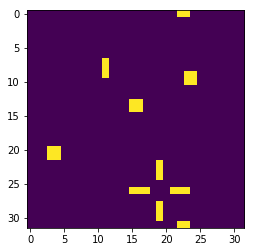

In [3]:
conway_ker = ker.get_function("conway_ker")
     
# set lattice size
N = 32

lattice = np.int32( np.random.choice([1,0], N*N, p=[0.25, 0.75]).reshape(N, N) )
lattice_gpu = gpuarray.to_gpu(lattice)
conway_ker(lattice_gpu, np.int32(100000), grid=(1,1,1), block=(32,32,1))
fig = plt.figure(1)
plt.imshow(lattice_gpu.get())
plt.show()
    
